In [21]:
import numpy as np
import cv2
import os
from math import ceil
import time
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import pandas as pd
%matplotlib inline

In [2]:
#建立相應資料夾
folders_target_list = ['ml100-03-final/processed image data/train/daisy',
           'ml100-03-final/processed image data/train/dandelion',
           'ml100-03-final/processed image data/train/rose',
           'ml100-03-final/processed image data/train/sunflower',
           'ml100-03-final/processed image data/train/tulip',
           'ml100-03-final/processed image data/test']
for d in folders_target_list:
    try:
        os.makedirs(d)
    except OSError:
        pass

In [3]:
def preprocessing_from_folder(f1, f2):
    for filename in os.listdir(f1):
        im = cv2.imread(os.path.join(f1, filename))
        h = im.shape[0]
        w = im.shape[1]
        #旋轉使其寬>高
        if(h > w):   
            im = np.rot90(im)
        h = im.shape[0]
        w = im.shape[1]
        #等比例調整使其高度是240
        r = 240/h
        im = cv2.resize(im, (ceil(w*r), 240), interpolation=cv2.INTER_CUBIC)
        h = im.shape[0]
        w = im.shape[1]
        #砍掉左右不需要的部分，只留下240*240 中間的正方形
        x_l = ceil((w-240)/2)
        crop_img = im[0:240, x_l:x_l+240]
        cv2.imwrite(os.path.join(f2, filename), crop_img)
       

In [4]:
folders_list = ['ml100-03-final/image_data/train/daisy',
           'ml100-03-final/image_data/train/dandelion',
           'ml100-03-final/image_data/train/rose',
           'ml100-03-final/image_data/train/sunflower',
           'ml100-03-final/image_data/train/tulip',
           'ml100-03-final/image_data/test']

In [ ]:
#圖片格式整理，並且另存整理後的圖片
for f1, f2 in zip(folders_list, folders_target_list):
    preprocessing_from_folder(f1, f2)

圖片格式整理前
type= <class 'numpy.ndarray'>  H:326 W:500


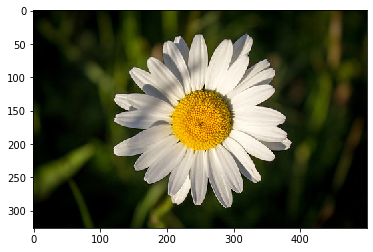

圖片格式整理後
type= <class 'numpy.ndarray'>  H:240 W:240


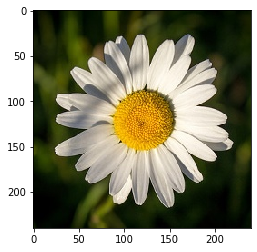

In [4]:
print('圖片格式整理前')
img = cv2.imread('ml100-03-final/image_data/train/daisy/0a3e7507742e246b3a2e630debbbaf99.jpg')
print('type=', type(img), ' H:%d W:%d'%((img.shape)[0], (img.shape)[1]))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print('圖片格式整理後')
img = cv2.imread('ml100-03-final/processed image data/train/daisy/0a3e7507742e246b3a2e630debbbaf99.jpg')
print('type=', type(img), ' H:%d W:%d'%((img.shape)[0], (img.shape)[1]))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
#建立 (x_train, y_train) 與 (x_test, y_test)

sr = 0.95 #分割要拿來train的比例

num_label = []
x_train = []
x_test = []
y_train = []
y_test = []
for i, f_path in enumerate(folders_target_list[:5]):
    ni = len(os.listdir(f_path))
    for j, filename in enumerate(os.listdir(f_path)):
        im = cv2.imread(os.path.join(f_path, filename))
        
        #label
        y_tmp = np.zeros((5,), dtype=int)
        y_tmp[i] = 1
        #將每一個label 中 sr比率的 (x, y) pair 拿來training 使用
        if(j < ceil(ni*sr)):
            x_train.append(im)
            y_train.append(y_tmp)
        else:
            x_test.append(im)
            y_test.append(y_tmp)
    num_label.append(ni)

In [6]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

#normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [7]:
print('type(x_train)=', type(x_train), ', dtype = ', x_train.dtype)
print('x_train shape = ', x_train.shape)

print('type(y_train)=', type(y_train), ', dtype = ', y_train.dtype)
print('y_train shape = ', y_train.shape)

print('type(x_test)=', type(x_test), ', dtype = ', x_test.dtype)
print('x_test shape = ', x_test.shape)

print('type(y_test)=', type(y_test), ', dtype = ', y_test.dtype)
print('y_test shape = ', y_test.shape)

print('total (x,y) pair = ', sum(num_label))
print('每個種類分別有幾個sample', num_label)

type(x_train)= <class 'numpy.ndarray'> , dtype =  float32
x_train shape =  (2684, 240, 240, 3)
type(y_train)= <class 'numpy.ndarray'> , dtype =  int32
y_train shape =  (2684, 5)
type(x_test)= <class 'numpy.ndarray'> , dtype =  float32
x_test shape =  (139, 240, 240, 3)
type(y_test)= <class 'numpy.ndarray'> , dtype =  int32
y_test shape =  (139, 5)
total (x,y) pair =  2823
每個種類分別有幾個sample [500, 687, 515, 488, 633]


In [8]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in enumerate(axes):
            nth=r
            if nth < nimg:
                ax.imshow(cv2.cvtColor(img[nth], cv2.COLOR_BGR2RGB), cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in enumerate(axes):
            nth=c
            if nth < nimg:
                ax.imshow(cv2.cvtColor(img[nth], cv2.COLOR_BGR2RGB), cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in enumerate(axes):
            for c, ax in enumerate(row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(cv2.cvtColor(img[nth], cv2.COLOR_BGR2RGB), cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

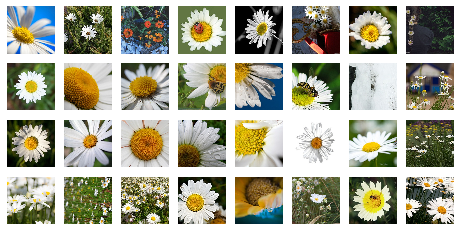

In [9]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [10]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam

Using TensorFlow backend.


In [58]:
# 建立 CNN model

# RTX 2080 才跑得動， Model 參數太多!
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(SeparableConv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(SeparableConv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(60))
model.add(Activation('relu'))
model.add(Dropout(0.40))
model.add(Dense(5))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['categorical_accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 240, 240, 32)      896       
_________________________________________________________________
activation_43 (Activation)   (None, 240, 240, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 238, 238, 32)      9248      
_________________________________________________________________
activation_44 (Activation)   (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 119, 119, 32)      0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 119, 119, 32)      0         
_________________________________________________________________
separable_conv2d_17 (Separab (None, 119, 119, 64)     

In [59]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [60]:
# training

batch_size = 20 # batch 的大小，如果出現 OOM error，請降低這個值

epochs = 200 # 訓練的 epochs 數量

time_array = time.localtime() # localtime
time_str = time.strftime('%m-%dT%H%M%S', time_array)

save_model_name = "model_"+time_str+".h5"
#存val_loss 最低的model的 call back func
model_ckpt = ModelCheckpoint(filepath="./"+save_model_name, 
                             monitor="val_loss",
                             save_weights_only = False,
                             save_best_only=True)


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    callbacks=[model_ckpt],
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2684 samples, validate on 139 samples
Epoch 1/200


KeyboardInterrupt: 

In [46]:
score1 = model.evaluate(x_test, y_test, verbose=1)
print(score1)

139/139 [==============================] - 0s 3ms/step
[1.1425330861866902, 0.597122311592102]


In [45]:
#載入訓練的模型
# model.load_weights("./tmp001.h5")
# model = keras.models.load_model("tmp002.h5")
model = keras.models.load_model(save_model_name)

In [47]:
df = pd.read_csv('ml100-03-final/sample_submission.csv')
test_file_name_list = list(df.id)

In [48]:
x_test_sub = [];
for i, f_name in enumerate(test_file_name_list):
    im = cv2.imread(os.path.join('ml100-03-final/processed image data/test', f_name+'.jpg'))
    x_test_sub.append(im)
x_test_sub = np.array(x_test_sub)

(2000, 240, 240, 3)
<class 'numpy.ndarray'>
(240, 240, 3)


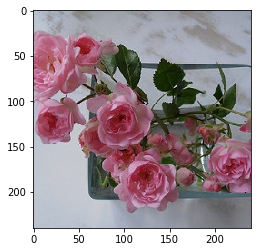

In [49]:
print(x_test_sub.shape)
test_img_01 = x_test_sub[0]
plt.imshow(cv2.cvtColor(test_img_01, cv2.COLOR_BGR2RGB))
print(type(test_img_01))
print(test_img_01.shape)

In [50]:
y_test_sub_predict = model.predict(x_test_sub)

In [51]:
print(type(y_test_sub_predict))
print(len(y_test_sub_predict))
print(y_test_sub_predict.shape)
print(y_test_sub_predict[0])
print(y_test_sub_predict[1])

<class 'numpy.ndarray'>
2000
(2000, 5)
[0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0.]


In [52]:
predict_label = np.zeros((len(y_test_sub_predict), ), dtype=int)
for i, item in enumerate(y_test_sub_predict):
    predict_label[i] = np.argmax(item)

In [53]:
print(type(predict_label))
print(len(predict_label))
print(predict_label)

<class 'numpy.ndarray'>
2000
[2 3 4 ... 0 3 2]


In [54]:
submission_df = pd.DataFrame()
submission_df['id'] = df['id']
submission_df['flower_class'] = predict_label
print(submission_df)

                                    id  flower_class
0     0028624c49b3e0610ff9f1d111f5d532             2
1     002c30700185b7971369258b438070d5             3
2     00852f4f666acecd0c0d140365b42efd             4
3     00c08828fce04e360c732cac01edad9e             4
4     00d366e7877b6a78b104b57d67b60e6b             2
...                                ...           ...
1995  ff7eac29b6d7a33fbd8009677c3e9c58             3
1996  ffbc32a7b67dfe72b8d35d4b1b35fd6c             3
1997  ffea1f275c05accb0a6bfd1203620c7e             0
1998  ffeb2a1cf53464b6af937ab8af0c2946             3
1999  ffefcc68e2e7eed8b17b0b5b0f740538             2

[2000 rows x 2 columns]


### 存檔成CSV

In [55]:
time_array = time.localtime() # localtime
time_str = time.strftime('%m-%dT%H%M%S', time_array)

submission_filename = 'Result_'+time_str+'.csv'
submission_df.to_csv(submission_filename, index=False)

* model_12-28T010428.h5 -> Public Score 0.46900